# Подключение библиотек

In [1]:
### Python2.7
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from scipy import stats

import pylab as pl
import seaborn as sns

pd.set_option('display.precision', 3);
sns.set(font_scale=1) # размер шрифта

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Загрузка данных

In [2]:
data = pd.read_csv('ccpp.csv', # путь к файлу,
                   sep=';', # разделитель данных в файле
                   decimal=",",# дробная часть отделяется запятой
                   header=0) # номер строки с заголовками

In [3]:
data.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


# 1. Результаты первичного анализа данных

## 1.1 Количество записей и признаков

In [4]:
nrow = data.shape[0]
ncol = data.shape[1]
print ("Итого: " + str(nrow) + " записи, " + str(ncol) + " столбец (признак).")

Итого: 9568 записи, 5 столбец (признак).


In [5]:
data.columns

Index([u'AT', u'V', u'AP', u'RH', u'PE'], dtype='object')

<h2>1.2 Смысловое описание признаков</h2>

- Температура (T) от 1.81°C до 37.11°C
- Атмосферное давление (AP) от 992.89 до 1033.30 милибар
- Относительная влажность (RH) от 25.56% до 100.16%
- Вакуум на выхлопе паровой трубы (V) от 25.36 до 81.56 см. рт. ст. ( [ссылка на перевод]( https://www.multitran.com/m.exe?l1=1&l2=2&s=exhaust%20vacuum) )
- Часовая выработка электроэнергии (PE) от 420.26 до 495.76 МегаВатт

Переименуем колонки для удобства:

In [6]:
data.columns = ([u'Temperature', u'Vacuum', u'Pressure',u'Humidity', u'EnergyOutput'])

In [7]:
data_origin = data
data.head()

,Temperature,Vacuum,Pressure,Humidity,EnergyOutput
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


## 1.3 Типы данных столбцов и инфморация о пропусках

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
Temperature     9568 non-null float64
Vacuum          9568 non-null float64
Pressure        9568 non-null float64
Humidity        9568 non-null float64
EnergyOutput    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB
None


In [9]:
data.describe()

,Temperature,Vacuum,Pressure,Humidity,EnergyOutput
count,9568.000,9568.000,9568.000,9568.000,9568.000
mean,19.651,54.306,1013.259,73.309,454.365
std,7.452,12.708,5.939,14.600,17.067
min,1.810,25.360,992.890,25.560,420.260
25%,13.510,41.740,1009.100,63.328,439.750
50%,20.345,52.080,1012.940,74.975,451.550
75%,25.720,66.540,1017.260,84.830,468.430
max,37.110,81.560,1033.300,100.160,495.760


In [10]:
data.isna().sum()

Temperature     0
Vacuum          0
Pressure        0
Humidity        0
EnergyOutput    0
dtype: int64

__Похоже данные без пропусков__

# 2. Обоснование выбора целевой переменной и признаков для анализа

## 2.1 Матрица коэффициентов корреляции

In [11]:
corrdf = data.corr(method='pearson')
print corrdf

              Temperature  Vacuum  Pressure  Humidity  EnergyOutput
Temperature         1.000   0.844    -0.508    -0.543        -0.948
Vacuum              0.844   1.000    -0.414    -0.312        -0.870
Pressure           -0.508  -0.414     1.000     0.100         0.518
Humidity           -0.543  -0.312     0.100     1.000         0.390
EnergyOutput       -0.948  -0.870     0.518     0.390         1.000


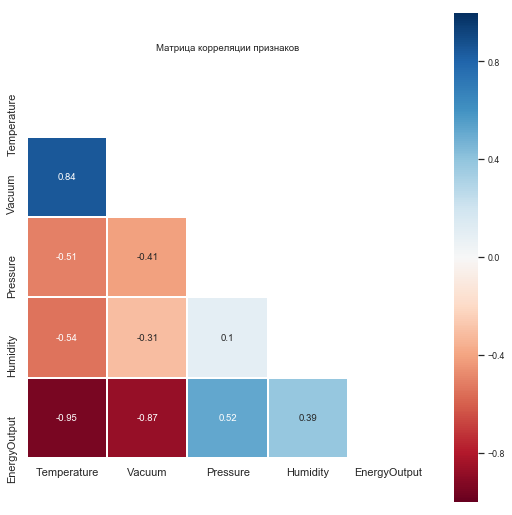

In [12]:
import matplotlib.pyplot as plt
sns.set(style="white")# цвет фона

# построить "маску" для отображения только половины корреляционной матрицы
mask = np.zeros_like(corrdf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9,9))
sns.set(font_scale=0.8) # размер шрифта

# Построить тепловую карту
sns.heatmap(data=corrdf, vmin=-1, vmax=1, center=0,
            annot=True, 
            cmap = 'RdBu',
            mask=mask,   # применить маску
            square=True, # форма ячейки - квадрат
            linewidths=1.0, # зазор между ячейки
           )
plt.title(u'Матрица корреляции признаков');

## 2.2 Матрица смежности (графический вариант интерпретации взаимосвязей переменных)

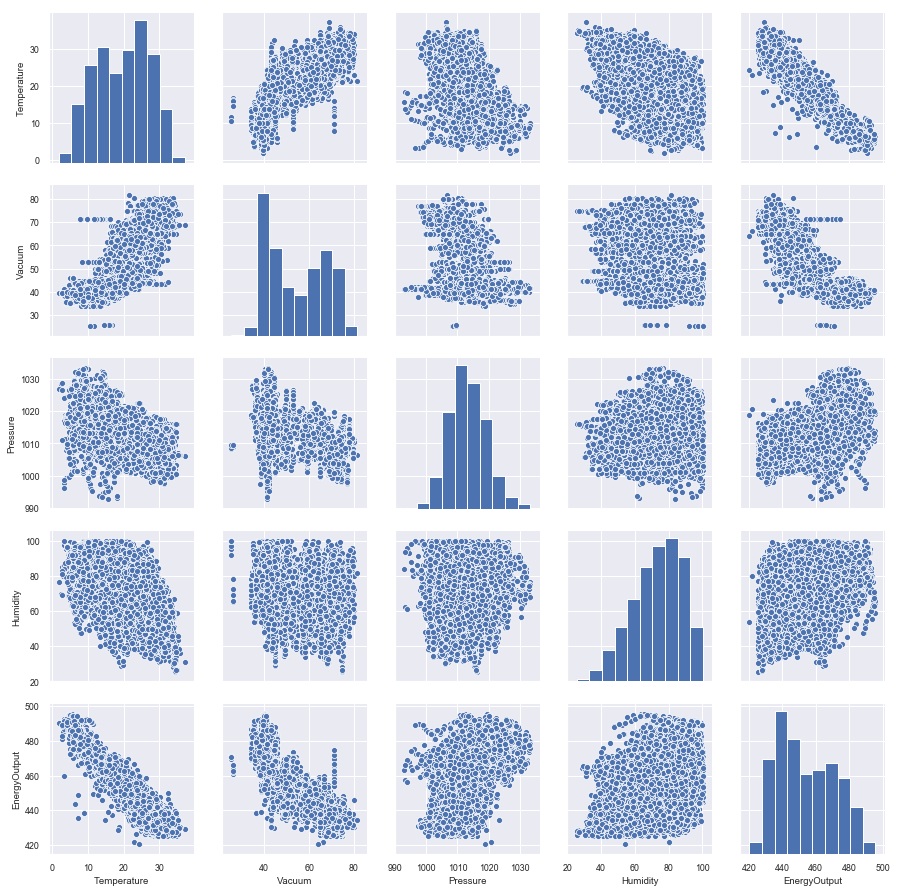

In [13]:
%config InlineBackend.figure_format = 'png'     
sns.pairplot(data)

# 2.3. Выбор целевого значения и признаков для анализа данных

На основе информации о взаимозависимости и степени влияния признаков выберем целевое значение:

В качестве целевой переменной была выбрана Часовая выработка электроэнергии (EP) так как предсказание этого параметра поможет оптизировать работу электростанции.

__Часовая выработка электроэнергии (целевая переменная)__ - сильно коррелирует с Температурой (-0.95), с Вакуумом на выхлопе паровой трубы (-0.87) и с Давлением (0.52). 

In [14]:
features = [u'Temperature', u'Vacuum', u'Pressure']
target = [u'EnergyOutput']

for features_name in features:
    print "{:<9}, {} = {:>6.3f}".format(features_name, target, corrdf[features_name][target[0]])

Temperature, [u'EnergyOutput'] = -0.948
Vacuum   , [u'EnergyOutput'] = -0.870
Pressure , [u'EnergyOutput'] =  0.518


In [15]:
test_corrdf2 = data[features + target].corr(method='pearson')
print test_corrdf2

              Temperature  Vacuum  Pressure  EnergyOutput
Temperature         1.000   0.844    -0.508        -0.948
Vacuum              0.844   1.000    -0.414        -0.870
Pressure           -0.508  -0.414     1.000         0.518
EnergyOutput       -0.948  -0.870     0.518         1.000


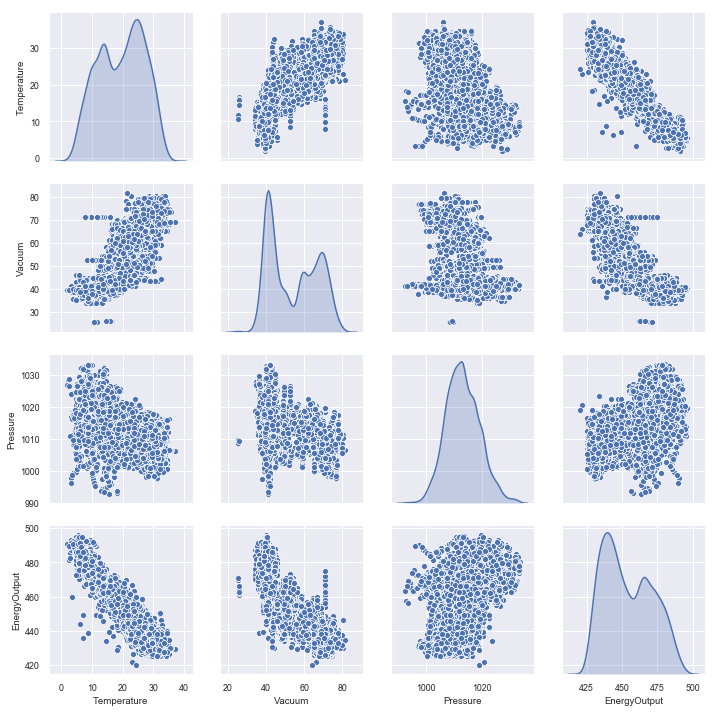

In [16]:
# График признаков попарно
%config InlineBackend.figure_format = 'png' # формат изображений PNG, для сокращения времени отрисовки графиков
sns.pairplot(data[features + target], 
            #hue = 'Type', # Признак разделения
            kind="scatter", # Тип даграмм: reg,scatter 
            diag_kind = 'kde', # Тип диагоральных даграмм: hist, kde
            ); 

Temperature 1.81 37.11
Vacuum 25.36 81.56
Pressure 992.89 1033.3


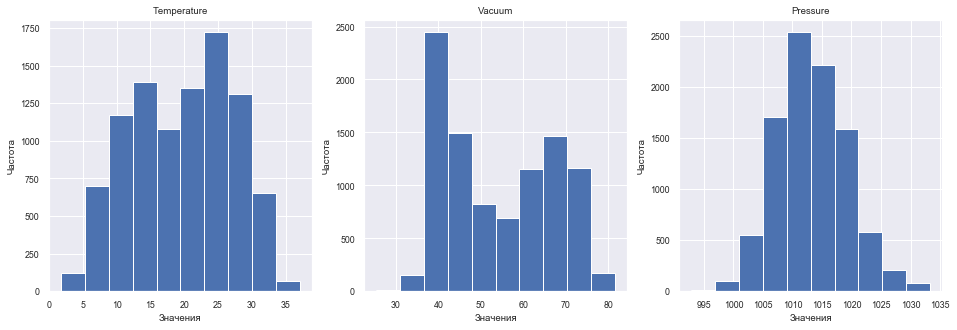

In [17]:
plt.figure(figsize(16, 5))
plot_number = 0
for feature_name in features:
    plot_number += 1
    plt.subplot(1,3,plot_number)
    plt.hist(data[feature_name])
    #plt.xlim( data[feature_name].min(), data[feature_name].max() )
    plt.title(feature_name)
    plt.xlabel(u'Значения')
    plt.ylabel(u'Частота')
    print feature_name, data[feature_name].min(), data[feature_name].max()

## Признак Vacuum

In [18]:
data[['Vacuum']].describe()

,Vacuum
count,9568.000
mean,54.306
std,12.708
min,25.360
25%,41.740
50%,52.080
75%,66.540
max,81.560


<Figure size 1152x360 with 0 Axes>

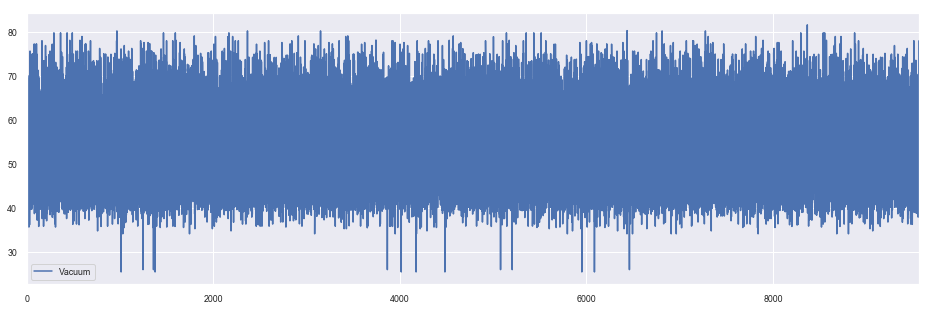

In [19]:
plt.figure(figsize(16, 5))
data[['Vacuum']].plot(kind='line')
#Отсутствие выбросов

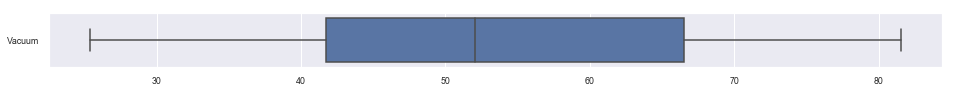

In [20]:
plt.figure(figsize(16, 1))
sns.boxplot( data=data[['Vacuum']], orient="h")

## Признак Temperature

<Figure size 1152x360 with 0 Axes>

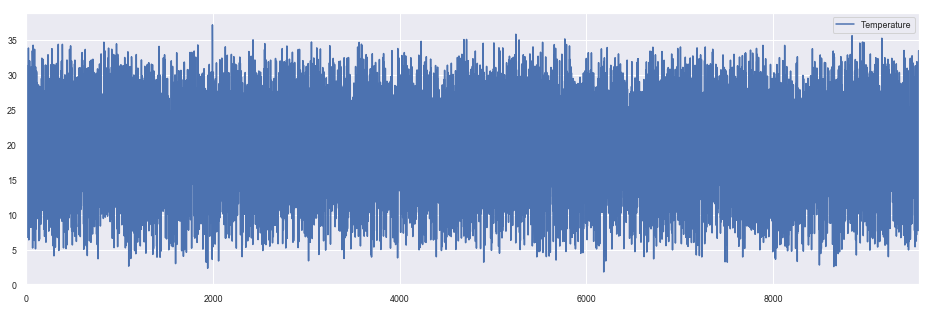

In [21]:
plt.figure(figsize(16, 5))
data[['Temperature']].plot(kind='line')

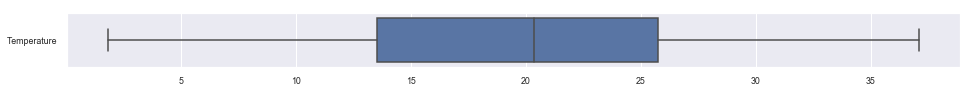

In [22]:
plt.figure(figsize(16, 1))
sns.boxplot( data=data[['Temperature']], orient="h")

## Признак Pressure

In [23]:
data[['Pressure']].describe()

,Pressure
count,9568.000
mean,1013.259
std,5.939
min,992.890
25%,1009.100
50%,1012.940
75%,1017.260
max,1033.300


<Figure size 1152x360 with 0 Axes>

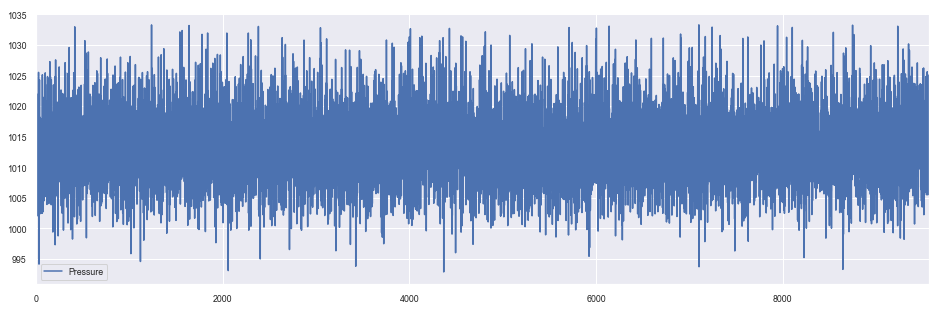

In [24]:
plt.figure(figsize(16, 5))
data[['Pressure']].plot(kind='line')

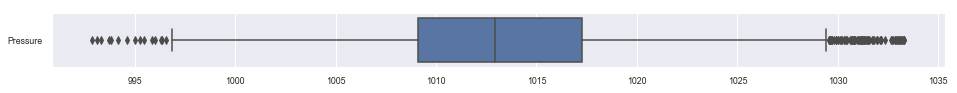

In [25]:
plt.figure(figsize(16, 1))
sns.boxplot( data=data[['Pressure']], orient="h")

((array([-3.79967944, -3.57391754, -3.44994448, ...,  3.44994448,
          3.57391754,  3.79967944]),
  array([420.26, 421.57, 425.11, ..., 495.24, 495.35, 495.76])),
 (16.68902629348609, 454.36500940635455, 0.9775408569880999))

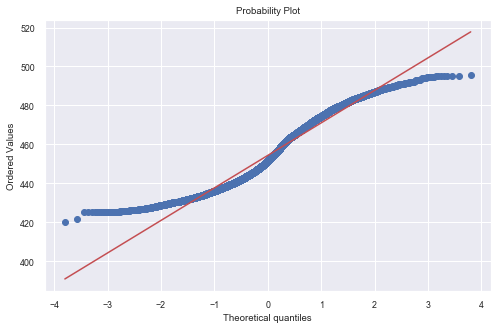

In [26]:
# диаграмма вероятности
plt.figure(figsize=(8,5))
stats.probplot(data['EnergyOutput'], plot=plt)

# 3. Построение регрессионных моделей

Разделим получившиеся данные на тренировочную (data_x_train, data_y_train) и проверочную части (x_test, y_test)

In [27]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел
x_train, x_test, y_train, y_test = train_test_split(
    data[features], data[target], # исходные данные
    test_size = valid_size,
    random_state=rand_seed,
    shuffle=True # перемешивание
)

In [28]:
print "Кол-во элементов: \n x_train: {}, y_train {} \n x_test: {}, y_test {} \n total x: {}, total y {} ".format(
    len(x_train), len(y_train),
    len(x_test), len(x_test),
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
 x_train: 6697, y_train 6697 
 x_test: 2871, y_test 2871 
 total x: 9568, total y 9568 


# 3.1 Линейная регрессия

### 3.1.1. Одномерная модель от признака 'Temperature'

In [29]:
lr = linear_model.LinearRegression()
x1 = x_train['Temperature'].values.reshape(-1, 1)
y1 = y_train['EnergyOutput'].values.reshape(-1, 1)
x2 = x_test['Temperature'].values.reshape(-1, 1)
y2 = y_test['EnergyOutput'].values.reshape(-1, 1)

In [30]:
# Вычислить коэфф. на тренировочном наборе
lin_model = lr.fit(x1, y1)
# Получить предсказание на проверочном наборе
y_pred = lin_model.predict(x2)

In [31]:
print (y_pred)

[[469.57729908]
 [438.23176681]
 [462.0014052 ]
 ...
 [473.96220041]
 [452.60208701]
 [429.41854929]]


<Figure size 720x720 with 0 Axes>

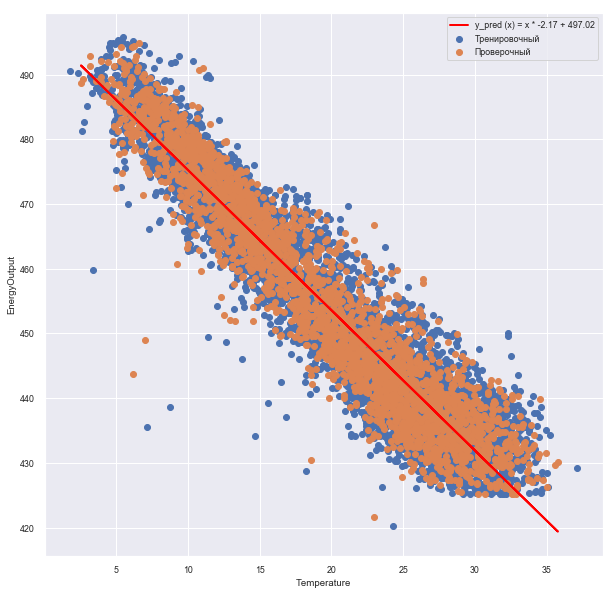

In [32]:
plt.figure(figsize(10,10))
fig, ax = plt.subplots()
ax.scatter(x1, y1, label=u'Тренировочный') # тренировочный
ax.scatter(x2, y2, label=u'Проверочный') # проверочный
ax.plot( x2, y_pred, lw=2, color='red',
label="y_pred (x) = x * {:.2f} + {:.2f}".format(lin_model.coef_[0][0], lin_model.intercept_[0]))
ax.legend(loc="best")
ax.set_xlabel('Temperature')
ax.set_ylabel(target[0])
plt.show()

Text(0.5,0,u'\u0417\u043d\u0430\u0447\u0435\u043d\u0438\u0435')

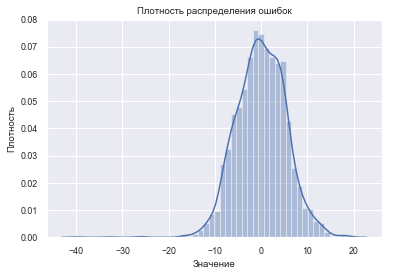

In [33]:
figure(figsize=(6,4))
sns.distplot(y2 - y_pred)
plt.plot(
    [0, 0],
    [0, 10 * pow(10,-7)], '--', lw=2, c='r')
plt.title(u'Плотность распределения ошибок');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение')

In [34]:
print "Линейная одномерная регрессия. признака 'Temperature'."
print (lin_model.coef_[0][0])
print "y_pred (x) = x * {:.2f} + {:.0f}\n".format(lin_model.coef_[0][0], lin_model.intercept_[0])
mae_LinRegr = metrics.mean_absolute_error(y2, y_pred)
rmse_LinRegr = np.sqrt( metrics.mean_squared_error(y2, y_pred) )
r2_LinRegr = metrics.r2_score (y2, y_pred)
print "MAE - средняя абсолютная ошибка: {:>7,.0f}".format( mae_LinRegr )
print "RMSE - кв. корень из средреквадратичной ошибки: {:>7,.0f}".format( rmse_LinRegr )
print "R2 - коэфф. детерминации: {:>7,.3f}".format( r2_LinRegr )

Линейная одномерная регрессия. признака 'Temperature'.
-2.170743232091295
y_pred (x) = x * -2.17 + 497

MAE - средняя абсолютная ошибка:       4
RMSE - кв. корень из средреквадратичной ошибки:       5
R2 - коэфф. детерминации:   0.902


In [35]:
df = { u'__Проверочное': y2.reshape(1,-1)[0],
    u'_Предсказанные': y_pred.reshape(1,-1)[0],
    u'Ошибка': (y2 - y_pred).reshape(1,-1)[0]}
df = pd.DataFrame(df)
df.head(15)

,__Проверочное,_Предсказанные,Ошибка
0,468.78,469.577,-0.797
1,442.91,438.232,4.678
2,459.47,462.001,-2.531
3,442.86,441.857,1.003
4,452.15,449.693,2.457
5,461.46,465.192,-3.732
6,445.09,446.003,-0.913
7,449.68,453.601,-3.921
8,485.94,483.687,2.253
9,456.86,458.637,-1.777


Text(0,0.5,u'\u041f\u0440\u0435\u0434\u0441\u043a\u0430\u0437\u0430\u043d\u043d\u043e\u0435 Y')

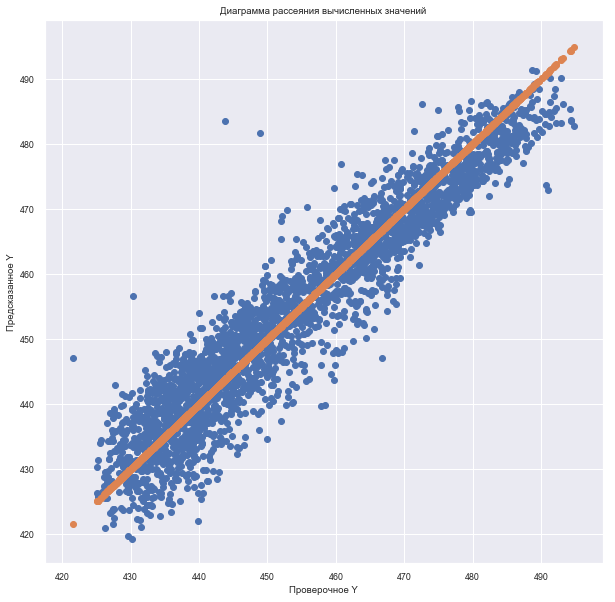

In [36]:
plt.figure(figsize(10,10))
plt.scatter(y2,y_pred)
plt.scatter(y2,y2)
plt.title(u'Диаграмма рассеяния вычисленных значений');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Предсказанное Y')

Text(0,0.5,u'\u0410\u0431\u0441\u043e\u043b\u044e\u0442\u043d\u0430\u044f \u043e\u0448\u0438\u0431\u043a\u0430')

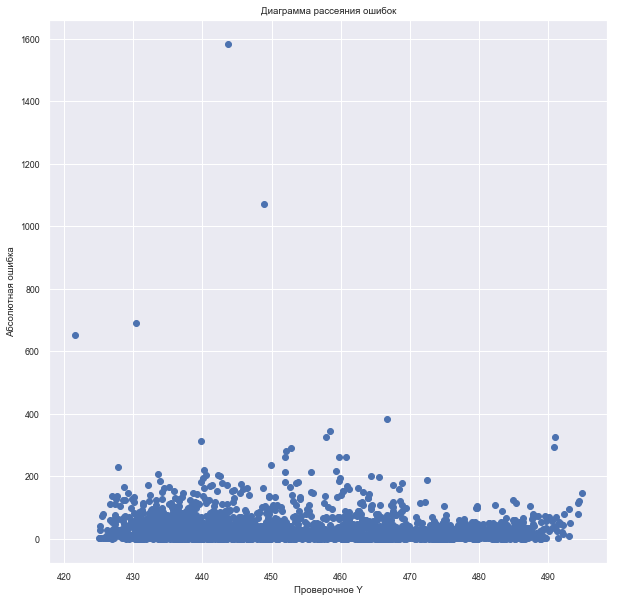

In [37]:
plt.scatter(y2,  (y2- y_pred) * (y2- y_pred))
plt.title(u'Диаграмма рассеяния ошибок')
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Абсолютная ошибка')

### 3.1.2. Одномерная модель от признака 'Vacuum'

In [38]:
lr = linear_model.LinearRegression()
x1 = x_train['Vacuum'].values.reshape(-1, 1)
y1 = y_train['EnergyOutput'].values.reshape(-1, 1)
x2 = x_test['Vacuum'].values.reshape(-1, 1)
y2 = y_test['EnergyOutput'].values.reshape(-1, 1)
lin_model = lr.fit(x1, y1)
y_pred = lin_model.predict(x2)

<Figure size 1080x360 with 0 Axes>

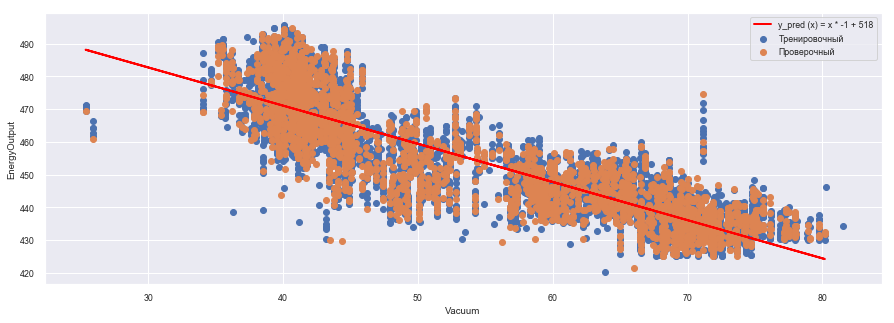

In [39]:
plt.figure(figsize(15,5))
fig, ax = plt.subplots()
ax.scatter(x1, y1, label=u'Тренировочный') # тренировочный
ax.scatter(x2, y2, label=u'Проверочный') # проверочный
ax.plot( x2, y_pred, lw=2, color='red',
label="y_pred (x) = x * {:.0f} + {:.0f}".format(lin_model.coef_[0][0], lin_model.intercept_[0]))
ax.legend(loc="best")
ax.set_xlabel('Vacuum')
ax.set_ylabel(target[0])
plt.show()

Text(0.5,0,u'\u0417\u043d\u0430\u0447\u0435\u043d\u0438\u0435')

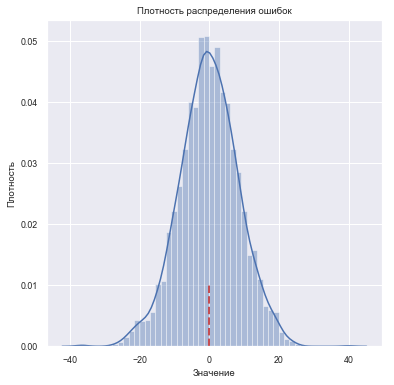

In [40]:
figure(figsize=(6,6))
sns.distplot(y2 - y_pred)
plt.plot(
    [0, 0],
    [0, 1 * pow(10,-2)], '--', lw=2, c='r')
plt.title(u'Плотность распределения ошибок');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение')

In [41]:
print "Линейная одномерная регрессия. признака 'Vacuum'."
print "y_pred (x) = x * {:.2f} + {:.2f}\n".format(lin_model.coef_[0][0], lin_model.intercept_[0])
mae_LinRegr = metrics.mean_absolute_error(y2, y_pred)
rmse_LinRegr = np.sqrt( metrics.mean_squared_error(y2, y_pred) )
r2_LinRegr = metrics.r2_score (y2, y_pred)
print "MAE - средняя абсолютная ошибка: {:>7,.2f}".format( mae_LinRegr )
print "RMSE - кв. корень из средреквадратичной ошибки: {:>7,.2f}".format( rmse_LinRegr )
print "R2 - коэфф. детерминации: {:>7,.3f}".format( r2_LinRegr )

Линейная одномерная регрессия. признака 'Vacuum'.
y_pred (x) = x * -1.17 + 517.77

MAE - средняя абсолютная ошибка:    6.70
RMSE - кв. корень из средреквадратичной ошибки:    8.52
R2 - коэфф. детерминации:   0.750


Text(0,0.5,u'\u041f\u0440\u0435\u0434\u0441\u043a\u0430\u0437\u0430\u043d\u043d\u043e\u0435 Y')

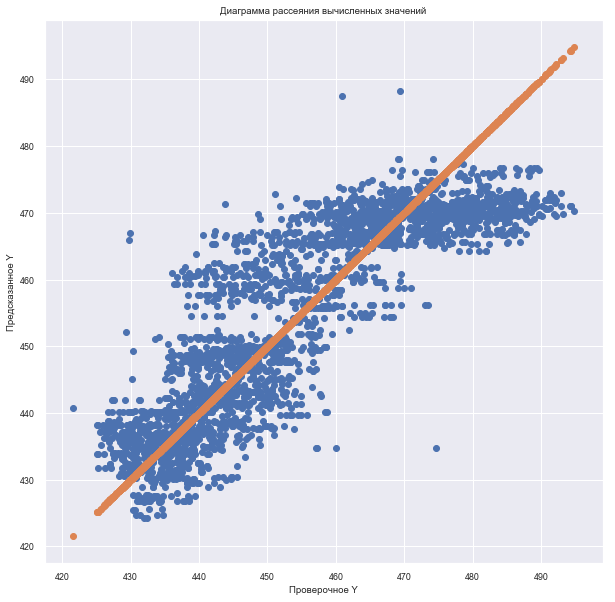

In [42]:
plt.figure(figsize(10,10))
plt.scatter(y2,y_pred)
plt.scatter(y2,y2)
plt.title(u'Диаграмма рассеяния вычисленных значений');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Предсказанное Y')

Text(0,0.5,u'\u0410\u0431\u0441\u043e\u043b\u044e\u0442\u043d\u0430\u044f \u043e\u0448\u0438\u0431\u043a\u0430')

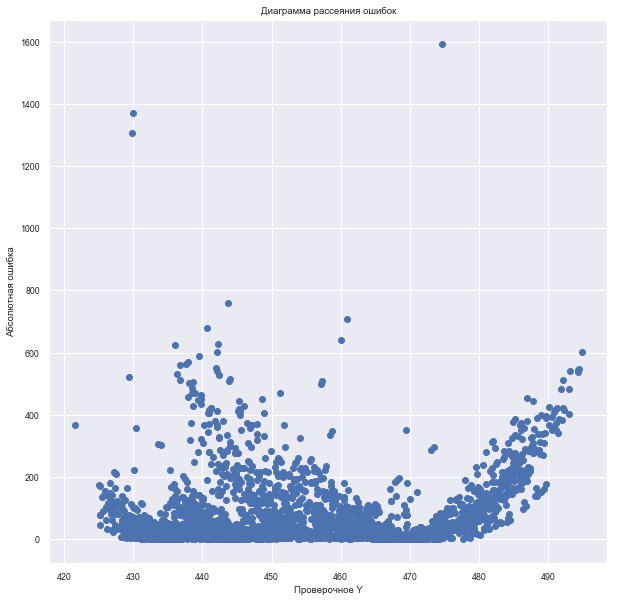

In [43]:
plt.scatter(y2,  (y2- y_pred) * (y2- y_pred))
plt.title(u'Диаграмма рассеяния ошибок')
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Абсолютная ошибка')

### 3.1.3. Одномерная модель от признака 'Pressure'

In [44]:
lr = linear_model.LinearRegression()
x1 = x_train['Pressure'].values.reshape(-1, 1)
y1 = y_train['EnergyOutput'].values.reshape(-1, 1)
x2 = x_test['Pressure'].values.reshape(-1, 1)
y2 = y_test['EnergyOutput'].values.reshape(-1, 1)
lin_model = lr.fit(x1, y1)
y_pred = lin_model.predict(x2)

<Figure size 720x720 with 0 Axes>

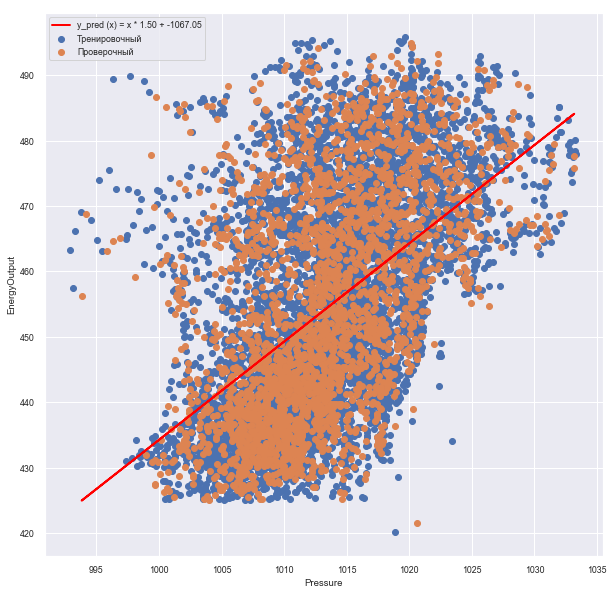

In [45]:
plt.figure(figsize(10,10))
fig, ax = plt.subplots()
ax.scatter(x1, y1, label=u'Тренировочный') # тренировочный
ax.scatter(x2, y2, label=u'Проверочный') # проверочный
ax.plot( x2, y_pred, lw=2, color='red',
label="y_pred (x) = x * {:.2f} + {:.2f}".format(lin_model.coef_[0][0], lin_model.intercept_[0]))
ax.legend(loc="best")
ax.set_xlabel('Pressure')
ax.set_ylabel(target[0])
plt.show()

Text(0.5,0,u'\u0417\u043d\u0430\u0447\u0435\u043d\u0438\u0435')

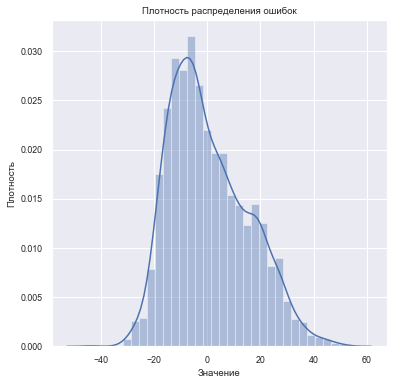

In [46]:
figure(figsize=(6,6))
sns.distplot(y2 - y_pred)
plt.plot(
    [0, 0],
    [0, 10 * pow(10,-7)], '--', lw=2, c='r')
plt.title(u'Плотность распределения ошибок');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение')

In [47]:
print "Линейная одномерная регрессия. признака 'Pressure'."
print "y_pred (x) = x * {:.2f} + {:.2f}\n".format(lin_model.coef_[0][0], lin_model.intercept_[0])
mae_LinRegr = metrics.mean_absolute_error(y2, y_pred)
rmse_LinRegr = np.sqrt( metrics.mean_squared_error(y2, y_pred) )
r2_LinRegr = metrics.r2_score (y2, y_pred)
print "MAE - средняя абсолютная ошибка: {:>7,.0f}".format( mae_LinRegr )
print "RMSE - кв. корень из средреквадратичной ошибки: {:>7,.0f}".format( rmse_LinRegr )
print "R2 - коэфф. детерминации: {:>7,.3f}".format( r2_LinRegr )

Линейная одномерная регрессия. признака 'Pressure'.
y_pred (x) = x * 1.50 + -1067.05

MAE - средняя абсолютная ошибка:      12
RMSE - кв. корень из средреквадратичной ошибки:      15
R2 - коэфф. детерминации:   0.253


Text(0,0.5,u'\u041f\u0440\u0435\u0434\u0441\u043a\u0430\u0437\u0430\u043d\u043d\u043e\u0435 Y')

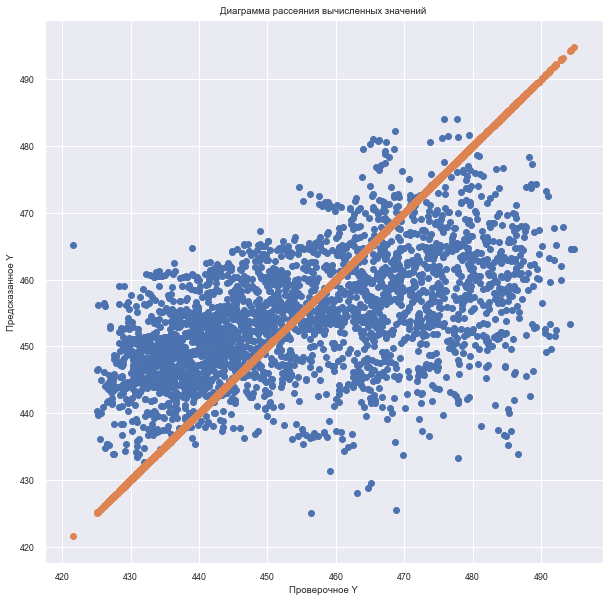

In [48]:
plt.figure(figsize(10,10))
plt.scatter(y2,y_pred)
plt.scatter(y2,y2)
plt.title(u'Диаграмма рассеяния вычисленных значений');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Предсказанное Y')

Text(0,0.5,u'\u0410\u0431\u0441\u043e\u043b\u044e\u0442\u043d\u0430\u044f \u043e\u0448\u0438\u0431\u043a\u0430')

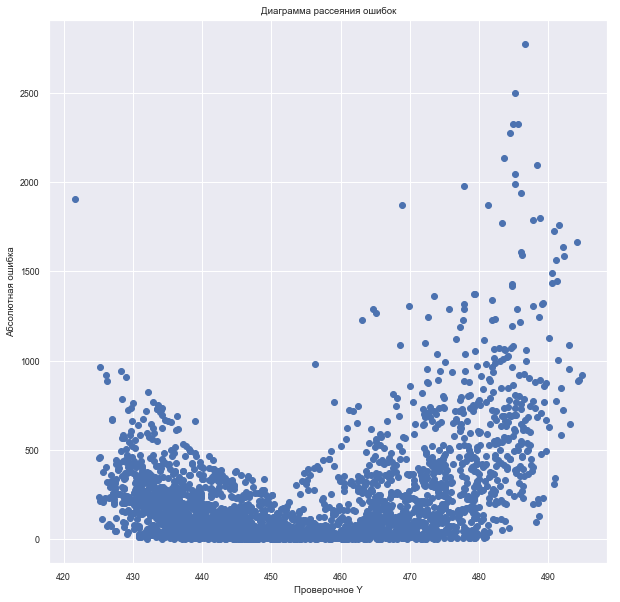

In [49]:
plt.scatter(y2,  (y2- y_pred) * (y2- y_pred))
plt.title(u'Диаграмма рассеяния ошибок')
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Абсолютная ошибка')

## Выводы
В ходе лабораторной работы был произведен анализ датасета электростанции, включаюшего признаки: Температура
Атмосферное давление, Относительная влажность, Вакуум на выхлопе паровой трубы, Часовая выработка электроэнергии. В ходе корреляционного анализа была выбрана целевая переменная __Часовая выработка электроэнергии__ и выявлены признаки сильно влияющие на целевую переменную: __Температура__ , __Вакуум на выхлопе паровой трубы__ и __Давление__. Стоит отметить, что данные были "чистые" (тоесть без пропусков и выбросов), что позволило не производить очистку данных.
Затем была построена линейная регрессия для каждого из параметров. Лучше всего (исходя из коэффициента детерминации) себе показала модель с призанком Температура _R2=0.902_)

In [50]:
ddf = pd.DataFrame (
    {
        u"Признак":["Temperature","Vacuum","Pressure"],
        u"K":[-2, -1, 2],
        u"B":[497, 518, -1067],
        u"MAE": [4, 7, 12],
        u"RMSE":[5, 9, 15],
        u"R2": [0.902, 0.750, 0.253],
    }
)
ddf

,B,K,MAE,R2,RMSE,Признак
0,497,-2,4,0.902,5,Temperature
1,518,-1,7,0.750,9,Vacuum
2,-1067,2,12,0.253,15,Pressure
